In [1]:
import requests
from bs4 import BeautifulSoup
    

<!doctype html><html dir="ltr" lang="de-DE"><head>      <meta data-react-helmet="true" charset="utf-8"/><meta data-react-helmet="true" name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover"/><meta data-react-helmet="true" name="robots" content="max-image-preview:large"/><meta data-react-helmet="true" name="robots" content="index, follow"/><meta data-react-helmet="true" name="referrer" content="no-referrer-when-downgrade"/><meta data-react-helmet="true" name="description" content="Mit der genauesten 10-Tage-Vorhersage für Tübingen, Baden-Württemberg mit Hoch- und Tiefdruckgebieten und der Niederschlagswahrscheinlichkeit von The Weather Channel und Weather.com sind Sie optimal vorbereitet"/><meta data-react-helmet="true" name="msapplication-TileColor" content="#ffffff"/><meta data-react-helmet="true" name="msapplication-TileImage" content="/daily/assets/ms-icon-144x144.d353af.png"/><meta data-react-helmet="true" name="theme-color" content="#ffffff"/><meta data-
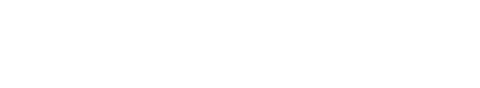
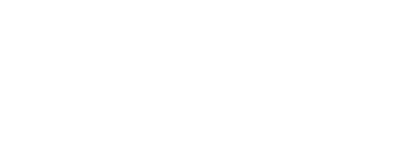

In [2]:
with open("response.html", "r") as file:
    content = file.readlines()


result = ""
for line in content:
    result += line.rstrip("\n")
print(result)

In [22]:
from itertools import chain


soup = BeautifulSoup(result, 'html.parser')

list(filter(lambda x: "region-meta" in x.attrs, soup.find_all("div")))

tags = soup.find_all("div")

ids = []
class_attrs = []
for tag in tags:
    try:
        class_attrs.append(tag.attrs["class"])
        ids.append(tag.attrs["id"])
    except KeyError:
        pass

list(chain.from_iterable(class_attrs)).index("DetailsSummary--DetailsSummary--1DqhO DetailsSummary--hourlyDetailsSummary--2xM-L")

ValueError: 'DetailsSummary--DetailsSummary--1DqhO DetailsSummary--hourlyDetailsSummary--2xM-L' is not in list

In [36]:
h3s = soup.find_all("h3")

print(h3s[2])
list(h3s[2].children)

<h3 class="DailyContent--daypartName--3emSU"><span class="DailyContent--daypartDate--3VGlz">Do. 21</span> | Tag</h3>


[<span class="DailyContent--daypartDate--3VGlz">Do. 21</span>, ' | Tag']

In [41]:
with open("response_hourly.html", "r") as file:
    content = file.readlines()

content = "".join(content).replace("\n", "")
html = BeautifulSoup(content)

In [47]:
list(html.find_all("h3")[1].parent.children)

[<h3 class="DetailsSummary--daypartName--kbngc" data-testid="daypartName">14:00</h3>,
 <div class="DetailsSummary--condition--2JmHb" data-testid="wxIcon"><svg class="DetailsSummary--wxIcon--1_A0F Icon--icon--2aW0V Icon--fullTheme--3Fc-5" data-testid="Icon" name="" set="weather" skycode="24" theme="full" viewbox="0 0 200 200"><title>Wind</title><use transform="matrix(1.25 0 0 1.25 -50 -44)" xlink:href="#svg-symbol-wind"></use><use transform="matrix(1.3 0 0 -1.25 -89 244)" xlink:href="#svg-symbol-wind"></use></svg><span class="DetailsSummary--extendedData--307Ax">Bedeckt/Wind</span></div>,
 <div class="DetailsSummary--temperature--1kVVp" data-testid="detailsTemperature"><span class="DetailsSummary--tempValue--jEiXE" data-testid="TemperatureValue">8<span>°</span></span></div>,
 <div class="DetailsSummary--precip--1a98O" data-testid="Precip"><svg aria-label="Regenwahrscheinlichkeit" class="DetailsSummary--precipIcon--1Cgzh Icon--icon--2aW0V Icon--actionTheme--1kPn8" data-testid="Icon" name

In [303]:
from abc import ABC, abstractmethod
from datetime import datetime as DateTime
from datetime import date as Date
from typing import Any, Callable, Dict, Iterable, Tuple
import bs4
from pandas import DataFrame

MONTHS_DE = [
    "Januar",
    "Februar",
    "März",
    "April",
    "Mai",
    "Juni",
    "Juli",
    "August",
    "September",
    "Oktober",
    "November",
    "Dezember",
]




class HTMLParser(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def parse(self, html_code: str) -> Dict[str, Any]:
        raise NotImplementedError


class TheWeatherChannelHourlyParser(HTMLParser):
    def __init__(self):
        pass

    def parse(self, html_code: str):
        html = BeautifulSoup(html_code)

        # find all h2 with with a date in the content
        forecast_html_structures = list(
            filter(
                has_attr(
                    attr_key="class", attr_value="HourlyForecast--DisclosureList--MQWP6"
                ),
                html.find_all("div"),
            )
        )[0]

        dt: DateTime  # DateTime variable
        data: Tuple[int, int, int]
        df_data = []
        for child in forecast_html_structures.children:
            # update date
            if child.name == "h2":
                date = get_date_from_h2(child)
            elif child.name == "details":
                # find time
                dt = self._get_datetime(tag=child, date=date)

                temp = self._get_temperature(tag=child)
                precip_prob = self._get_precipitation_prob(tag=child)
                precip = self._get_precipitation(tag=child)
                humidity = self._get_humidity(tag=child)

                df_data.append(
                    {
                        "time": dt,
                        "temperature": temp,
                        "precipitation": precip,
                        "precipitation_probability": precip_prob,
                        "humidity": humidity,
                    }
                )

        df = DataFrame(df_data)
        # split into individual dfs
        result = {}
        for feature_name in df.columns[1:]:
            result[feature_name] = df[["time", feature_name]]

    @staticmethod
    def _get_datetime(tag: bs4.element.Tag, date: Tuple[int, int, int]) -> DateTime:
        hour, minute = tag.find("h3").contents[0].split(":")
        hour = int(hour)
        minute = int(minute)
        dt = DateTime(*date, hour, minute)
        return dt

    @staticmethod
    def _get_temperature(tag: bs4.element.Tag) -> float:
        temp = get_content(
            has_attr("data-testid", "TemperatureValue"), tag.find_all("span")
        )
        # get real temp
        temp = int(temp[0][0])
        return temp

    @staticmethod
    def _get_precipitation_prob(tag: bs4.element.Tag) -> float:
        precip_prob = get_content(
            has_attr("data-testid", "PercentageValue"), tag.find_all("span")
        )
        # get percentage from string
        precip_prob = float(flatten(precip_prob)[0].rstrip("%")) / 100
        return precip_prob

    @staticmethod
    def _get_precipitation(tag: bs4.element.Tag) -> float:
        precip = get_content(
            has_attr("data-testid", "AccumulationValue"), tag.find_all("span")
        )
        precip = flatten(precip)[0].contents[0]

    @staticmethod
    def _get_humidity(tag: bs4.element.Tag) -> float:
        humidity = get_content(
            has_attr("data-testid", "PercentageValue"), tag.find_all("span")
        )
        # get percentage from string
        humidity = float(flatten(humidity)[1].rstrip("%")) / 100
        return humidity


class TheWeatherChannel10DayParser(HTMLParser):
    def __init__(self):
        pass

    def parse(self, html_code: str):
        html = BeautifulSoup(html_code)

        forecasts = filter(
            has_attr(
                attr_key="class", attr_value="DaypartDetails--DayPartDetail--2XOOV"
            ),
            html.find_all("details"),
        )

        for child in forecasts:
            date = self._get_date(tag=child)
            
            min_temp, max_temp = self._get_temp(tag=child)
            precip_prob = self._get_precipitation_probability(tag=child)

    
    @staticmethod
    def _get_date(tag: bs4.element.Tag) -> Date:
        day = int(get_content(has_attr("class", "DailyContent--daypartDate--3VGlz"), tag.find_all("span"))[0][0].split(" ")[-1])
        # current_day = DateTime.now().day
        current_day = 21
        current_month = DateTime.now().month
        current_year = DateTime.now().year

        month = current_month
        if day < current_day:
            month += 1
        year = current_year
        if month / 12 > 1:
            year += 1
        month %= 12
        if month == 0:
            month = 12

        date = Date(year, month, day)
        return date
            
    @staticmethod
    def _get_temp(tag: bs4.element.Tag) -> Tuple[int, int]:
        values = get_content(has_attr(attr_key="data-testid", attr_value="TemperatureValue"), tag.find_all("span"))
        values = flatten(values)
        temps = set(filter(lambda x: str(x).isnumeric(), values))
        temps = map(lambda x: int(x), temps)
        temps = tuple(sorted(temps))
        return temps
    
    @staticmethod
    def _get_precipitation_probability(tag: bs4.element.Tag) -> float:
        values = get_content(has_attr(attr_key="data-testid", attr_value="c"), tag.find_all("span"))
        print(values)

def load_html_content(path: str) -> str:
    with open(path, "r") as file:
        content = file.readlines()

    content = "".join(content).replace("\n", "")
    return content


def flatten(l):
    return list(chain.from_iterable(l))


def has_attr(attr_key: str, attr_value: str) -> bool:
    def filter_func(tag: bs4.element.Tag):
        if not tag.has_attr(attr_key):
            return False

        if attr_value in tag.attrs[attr_key]:
            return True

        return False

    return filter_func


def get_content(
    match_criteria_func: Callable[..., bool], tags: Iterable[bs4.element.Tag]
):
    result = [tag.contents for tag in filter(match_criteria_func, tags)]
    return result


def get_date_from_h2(h2: bs4.element.Tag) -> Tuple[int, int, int]:
    """_summary_

    Args:
        h2 (bs4.element.Tag): _description_

    Returns:
        Tuple[int, int, int]: year, month, day
    """
    day = h2.contents[0]
    _, day, forecast_month = day.split(" ")
    day = int(day.rstrip("."))
    forecast_month_idx = MONTHS_DE.index(forecast_month) + 1
    year = (
        DateTime.now().year
        if forecast_month_idx >= DateTime.now().month
        else DateTime.now().year + 1
    )

    return int(year), int(forecast_month_idx), day


hourly_parser = TheWeatherChannelHourlyParser()
hourly_content = hourly_parser.parse(load_html_content("response_hourly.html"))

daily_parser = TheWeatherChannel10DayParser()
daily_content = daily_parser.parse(load_html_content("response_daily.html"))

[['94%'], ['94%'], ['83%'], ['77%'], ['87%']]
[['83%'], ['83%'], ['85%'], ['79%'], ['89%']]
[['44%'], ['44%'], ['86%'], ['23%'], ['85%']]
[['22%'], ['22%'], ['78%'], ['21%'], ['80%']]
[['7%'], ['7%'], ['67%'], ['11%'], ['68%']]
[['11%'], ['11%'], ['65%'], ['11%'], ['82%']]
[['22%'], ['22%'], ['75%'], ['36%'], ['75%']]
[['44%'], ['44%'], ['77%'], ['36%'], ['84%']]
[['33%'], ['33%'], ['81%'], ['38%'], ['86%']]
[['38%'], ['38%'], ['77%'], ['46%'], ['82%']]
[['56%'], ['56%'], ['80%'], ['51%'], ['88%']]
[['52%'], ['52%'], ['85%'], ['60%'], ['87%']]
[['48%'], ['48%'], ['81%'], ['60%'], ['86%']]
[['49%'], ['49%'], ['82%'], ['49%'], ['87%']]
[['42%'], ['42%'], ['83%'], ['43%'], ['88%']]


In [318]:
from typing import Any, Dict


class WetterOnlineParser(HTMLParser):
    def __init__(self):
        super().__init__()

    def parse(self, html_code: str) -> Dict[str, Any]:
        html = BeautifulSoup(html_code)
        
        print(html.find_all("div"))
        forecast = list(filter(has_attr(attr_key="class", attr_value="temperature"), html.find_all("div")))
        print(len(forecast))

parser = WetterOnlineParser()
content = parser.parse(load_html_content("snapshot.html"))

[<div class='\"lp-tt' lp-tt-top\"="">\n    <div class='\"lp-tt-content\"'>\n      <div id='\"lp-tt-time\"'></div>\n      <div id='\"lp-tt-descr\"'></div>\n      <div class='\"para\"\n' id='\"lp-tt-air-pressure\"\n' none;\"="" style='\"display:'></div>\n      <div class='\"para\"\n' id='\"lp-tt-humidity\"\n' none;\"="" style='\"display:'></div>\n      <div class='\"para\"\n' id='\"lp-tt-temp\"\n' none;\"="" style='\"display:'></div>\n      <div class='\"para\"\n' id='\"lp-tt-wind\"'></div>\n      <div class='\"para\"\n' id='\"lp-tt-gust\"'></div>\n      <div class='\"para\"\n' id='\"lp-tt-prec\"'></div>\n      <div class='\"para\"\n' id='\"lp-tt-smog\"\n' none;\"="" style='\"display:'>Smog</div>\n    </div>\n  </div>, <div class='\"lp-tt-content\"'>\n      <div id='\"lp-tt-time\"'></div>\n      <div id='\"lp-tt-descr\"'></div>\n      <div class='\"para\"\n' id='\"lp-tt-air-pressure\"\n' none;\"="" style='\"display:'></div>\n      <div class='\"para\"\n' id='\"lp-tt-humidity\"\n' none;\"

HTTPError: HTTP Error 403: Forbidden

In [264]:
from abc import ABC, abstractmethod
from typing import List
from pandas import DataFrame
import json
import pandas as pd
import numpy as np
import datetime


class Converter(ABC):
    def __init__(self) -> None:
        pass

    @abstractmethod
    def to_df(self, data: object) -> List[DataFrame]:
        """convert data to a DataFrame

        Args:
            data (object): _description_

        Raises:
            NotImplementedError: if method is not implemented

        Returns:
            DataFrame: data in a DataFrame object
        """
        raise NotImplementedError


class DWDJsonConverter(Converter):
    def __init__(self) -> None:
        super().__init__()
        self._features_of_interest = [
            "temperature",
            "windSpeed",
            "windDirection",
            "precipitationTotal",
            "surfacePressure",
            "humidity",
            "temperatureStd",
            "precipitationProbablity",
        ]

    def to_df(self, data: Dict[str, Any]) -> List[DataFrame]:
        frames = []
        for station_name, station_data in data.items():
            frames.append(self._station_to_df(station_name, station_data))

        result = self._merge_dfs(*frames)
        print(result.keys())
        return result

    def _station_to_df(
        self, station_id: str, station_data: Dict[str, Any]
    ) -> List[DataFrame]:
        forecast1 = self._forecast_to_df(station_data["forecast1"])
        forecast1 = insert_column(forecast1, column_name="provider", value="DWD_1")
        forecast2 = self._forecast_to_df(station_data["forecast2"])
        forecast2 = insert_column(forecast2, column_name="provider", value="DWD_2")
        dwd_forecast = self._merge_dfs(forecast1, forecast2)
        dwd_forecast = insert_column(dwd_forecast, "station_id", station_id)
        return dwd_forecast

    def _forecast_to_df(self, forecast_data: Dict[str, Any]) -> List[DataFrame]:
        start = forecast_data["start"]
        time_step = forecast_data["timeStep"]
        frames = {}
        for feature_name in self._features_of_interest:
            feature = forecast_data[feature_name]

            if feature is None:
                frames[feature_name] = DataFrame(columns=("time", feature_name))
                continue

            length = len(feature)
            time = np.arange(start, start + length * time_step, time_step) / 1000
            time = np.array(
                [datetime.datetime.utcfromtimestamp(time_stamp) for time_stamp in time]
            )
            frames[feature_name] = DataFrame({"time": time, feature_name: feature})

        return frames

    def _merge_dfs(self, *df_dicts: Dict[str, DataFrame]):
        result = {}
        for feature_name in self._features_of_interest:
            frames = [dfs[feature_name] for dfs in df_dicts]
            result[feature_name] = pd.concat(frames)
        return result


def insert_column(
    dfs: Dict[str, DataFrame], column_name: str, value: List[Any] | Any, loc: int = 0
):
    for key in dfs.keys():
        dfs[key].insert(loc, column_name, value)
    return dfs


def load_json(path) -> Dict[str, Any]:
    with open(path, "r") as file:
        content = json.load(file)

    return content


import glob
import os

converter = DWDJsonConverter()
for file_name in glob.glob("../data/dwd/raw/*.json"):
    call_time_utc = int(file_name.split("/")[-1].split(".")[0])
    data = load_json(file_name)

    dfs = converter.to_df(data)
    dfs = insert_column(
        dfs,
        column_name="call_time",
        value=datetime.datetime.utcfromtimestamp(call_time_utc),
    )
    write_base_path = "../data/dwd/test/"
    # os.makedirs(write_base_path + str(call_time_utc))

    for key, df in filter(lambda x: bool(len(x[1])), dfs.items()):
        df.to_csv(write_base_path + str(call_time_utc) + "/" + key + ".csv")




"""
converter = DWDJsonConverter()
file_name = 1702167001
data = load_json(f"../data/dwd/test/{file_name}.json")

dfs = converter.to_df(data)
dfs = insert_column(
    dfs, column_name="call_time", value=datetime.datetime.utcfromtimestamp(file_name)
)
for df in dfs.values():
    print(len(df)) """

/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result[feature_name] = pd.concat(frames)
/tmp/ipykernel_13267/4171045594.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

dict_keys(['temperature', 'windSpeed', 'windDirection', 'precipitationTotal', 'surfacePressure', 'humidity', 'temperatureStd', 'precipitationProbablity'])


'\nconverter = DWDJsonConverter()\nfile_name = 1702167001\ndata = load_json(f"../data/dwd/test/{file_name}.json")\n\ndfs = converter.to_df(data)\ndfs = insert_column(\n    dfs, column_name="call_time", value=datetime.datetime.utcfromtimestamp(file_name)\n)\nfor df in dfs.values():\n    print(len(df)) '